Purpose: Run a preliminary random forest to classify samples as either control or stressed in a single stressor with lots of samples (drought).<br>
Author: Anna Pardo<br>
Date initiated: June 12, 2023

In [1]:
# import modules
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE

In [2]:
# load log TPM matrix (low-variance features already removed with VarianceThreshold)

vttpm_log = pd.read_csv("../../data/logTPM_allsamples_16-May-2023.txt",sep="\t",header="infer")
vttpm_log.head()

,Sample,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
0,B73xMO17_HII_1_BRB1,1.638809,2.220060,0.0,3.608334,0.000000,3.246090,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,B73xMO17_HII_2_BRB3,1.411726,1.015722,0.0,1.467345,0.000000,2.666771,0.0,0.0,0.496737,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,B73xMO17_HI_2_BRB4,1.525312,0.585677,0.0,1.638883,0.050644,2.615085,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,B73xMO17_HII_3_BRB4,1.856313,1.782950,0.0,1.282574,0.059865,2.775211,0.0,0.0,1.116139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,B73xMO17_HI_3_BRB6,1.212664,1.257071,0.0,0.000000,0.000000,2.086426,0.0,0.0,0.640717,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# load metadata (only columns Sample, BioProject, and Treatment are required)
md = pd.read_csv("../../data/srr_numbers_with_metadata_12-May-2023.csv",sep=",",header="infer",usecols=["BioProject","Sample","Treatment"])
md.head()

,BioProject,Sample,Treatment
0,PRJNA637522,SRR11933261,Drought
1,PRJNA637522,SRR11933272,Drought
2,PRJNA637522,SRR11933250,Drought
3,PRJNA637522,SRR11933029,Control
4,PRJNA637522,SRR11933040,Drought


In [4]:
# only for this preliminary random forest: drop all non-drought BioProjects
## start by dropping all samples not labeled drought or control
mddc = md[md["Treatment"].isin(["Drought","DroughtRepeat","Control"])]

In [5]:
# now remove all BioProjects that only have control samples
for b in mddc["BioProject"].unique():
    df = mddc[mddc["BioProject"]==b]
    if len(df["Treatment"].unique()) == 1:
        mddc = mddc[mddc["BioProject"] != b]

In [6]:
# set Control to 0 and any stress to 1
proxy = []
for i in range(len(mddc.index)):
    if mddc.iloc[i,2] == "Control":
        proxy.append(0)
    else:
        proxy.append(1)
mddc["Label"] = proxy

In [7]:
# merge labels with log TPM
labeled = mddc[["Sample","Label"]].merge(vttpm_log)
labeled.head()

,Sample,Label,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
0,SRR11933261,1,3.760627,1.731651,0.060075,3.800400,2.644723,3.597631,0.494946,0.0,...,0.227968,0.000000,0.0,0.0,0.0,0.389017,0.0,0.000000,0.0,0.000000
1,SRR11933272,1,4.109013,2.039269,0.490802,3.038092,1.537277,1.742518,0.226885,0.0,...,0.148026,0.173611,0.0,0.0,0.0,2.945473,0.0,0.000000,0.0,0.000000
2,SRR11933250,1,3.326079,1.994391,0.000000,2.032962,1.842599,4.103174,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.503415,0.0,0.326679,0.0,1.146231
3,SRR11933029,0,3.201844,1.759475,0.000000,1.447213,1.549133,4.364607,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.244933
4,SRR11933040,1,3.507319,1.925657,0.000000,1.189432,2.254362,4.372791,0.193789,0.0,...,0.236712,0.017435,0.0,0.0,0.0,3.409421,0.0,0.000000,0.0,1.745435


In [8]:
# drop any rows with NAs
## in this case there are none to drop
labeled.dropna(inplace=True)

In [9]:
len(labeled.index)

985

In [9]:
# set Sample as the index
labeled.set_index("Sample",inplace=True)

In [11]:
# check if the data are balanced
labeled["Label"].value_counts()

1    608
0    377
Name: Label, dtype: int64

In [12]:
labeled.head()

,Label,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
Sample,,,,,,,,,,,,,,,,,,,,,
SRR11933261,1,3.760627,1.731651,0.060075,3.800400,2.644723,3.597631,0.494946,0.0,1.086039,...,0.227968,0.000000,0.0,0.0,0.0,0.389017,0.0,0.000000,0.0,0.000000
SRR11933272,1,4.109013,2.039269,0.490802,3.038092,1.537277,1.742518,0.226885,0.0,1.714098,...,0.148026,0.173611,0.0,0.0,0.0,2.945473,0.0,0.000000,0.0,0.000000
SRR11933250,1,3.326079,1.994391,0.000000,2.032962,1.842599,4.103174,0.000000,0.0,1.540259,...,0.000000,0.000000,0.0,0.0,0.0,0.503415,0.0,0.326679,0.0,1.146231
SRR11933029,0,3.201844,1.759475,0.000000,1.447213,1.549133,4.364607,0.000000,0.0,1.389265,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.244933
SRR11933040,1,3.507319,1.925657,0.000000,1.189432,2.254362,4.372791,0.193789,0.0,1.706813,...,0.236712,0.017435,0.0,0.0,0.0,3.409421,0.0,0.000000,0.0,1.745435


In [13]:
# data are very biased, we can downsample or upsample
# let's downsample for now

# subset the merged data to only drought samples (labeled with 1)
ones_only = labeled[labeled["Label"]==1]

In [14]:
# now downsample from this subsetted dataframe
ds = ones_only.sample(n=377, random_state=42)

In [15]:
# pull out controls
zeroes_only = labeled[labeled["Label"]==0]

In [16]:
# concatenate the controls and downsampled drought samples
downsampled = pd.concat([ds,zeroes_only])

In [17]:
# check to make sure the downsampling worked
downsampled["Label"].value_counts()

1    377
0    377
Name: Label, dtype: int64

In [18]:
# Separate features (gene expression values) and target (class labels)
## where X = gene expression values and y = class labels
X = downsampled.drop("Label",axis=1)
y = downsampled["Label"]

In [19]:
# Split the data into training (75%) and testing (25%) sets
# note for future reference: this should be done as early in the process as possible and definitely before any imputation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [10]:
# create dictionary of parameters we want to search
# these came from a blog post Serena found
random_search_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['sqrt','log2','none'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [21]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across n different combinations, and use all available cores
## where n = number of combinations my computer can handle
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_search_grid, n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, max_depth=90, max_features=none, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, max_depth=90, max_features=none, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=   8.1s
[CV] END bootstrap=False, max_depth=30, max_features=none, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=none, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=none, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=none, min_samples_leaf=4, min_samples_split=10, n_estimat

/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
110 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/base.py", line 581, in _validate_params
    validate_parameter_constraints(
  File 

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['sqrt', 'log2',
                                                         'none'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [22]:
# Make predictions on the testing set
y_pred = rf_random.predict(X_test)

In [23]:
# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8253968253968254
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82        88
           1       0.87      0.79      0.83       101

    accuracy                           0.83       189
   macro avg       0.83      0.83      0.83       189
weighted avg       0.83      0.83      0.83       189



In [24]:
# find false negative samples
cm = confusion_matrix(y_test, y_pred)
false_negatives = []

for i in range(len(y_test)):
    if y_test.iloc[i] == 1 and y_pred[i] == 0:
        false_negatives.append((X_test.iloc[i], y_test.index[i]))

false_negatives_df = pd.DataFrame([item[0] for item in false_negatives], index=[item[1] for item in false_negatives])
false_negatives_df

,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,Zm00001eb000140,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
SRR11932887,3.930997,2.160143,0.000000,3.847900,2.972431,4.556474,0.000000,3.352449,1.728727,0.000000,...,0.000000,0.072236,0.000000,0.000000,3.331428,0.571953,0.0,0.330126,0.0,0.918571
SRR5358810,2.788346,0.600507,0.694710,1.738436,0.076610,0.061892,0.000000,0.000000,0.812257,0.249994,...,0.000000,0.031212,0.171359,0.000000,0.000000,0.235726,0.0,0.000000,0.0,0.000000
SRR11932835,3.975451,1.864678,0.000000,3.961821,4.315331,4.905350,0.355470,0.000000,0.508747,1.297477,...,0.447198,0.014097,0.000000,0.000000,0.454004,0.567722,0.0,0.569431,0.0,2.292665
SRR11933183,4.000961,2.323151,0.998971,4.752339,2.175831,4.696639,0.699178,0.000000,1.499110,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.827673,0.0,0.000000,0.0,0.000000
SRR11932854,3.679850,1.607953,0.000000,0.000000,0.886000,3.835358,0.122903,0.000000,1.025712,1.645049,...,0.000000,1.469589,0.000000,0.000000,0.000000,0.362928,0.0,0.000000,0.0,1.149641
SRR11933417,3.361225,1.671927,0.000000,3.257578,2.550058,1.513025,0.255926,0.000000,0.168512,0.000000,...,0.000000,0.015500,0.000000,0.000000,0.425651,0.367692,0.0,0.310020,0.0,0.000000
SRR10253755,3.858020,0.655997,0.584301,4.805019,0.000000,0.205809,0.050124,0.000000,1.560915,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.006525,0.000000,0.0,0.000000,0.0,0.000000
SRR2129985,4.270259,3.190097,0.000000,5.842444,0.725862,4.882103,0.241649,0.000000,1.710503,2.067896,...,0.090763,0.404651,0.000000,0.000000,0.000000,0.911524,0.0,0.000000,0.0,0.000000
SRR2144442,2.069541,5.802851,0.000000,4.060045,1.957277,5.292778,0.000000,0.000000,0.232197,0.000000,...,0.826828,2.056299,0.000000,0.000000,0.000000,0.000000,0.0,1.067960,0.0,0.945142
SRR11932979,2.823925,1.164723,0.000000,3.409272,3.808139,3.046298,0.000000,0.000000,0.000000,1.224385,...,0.090977,0.064904,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.069750


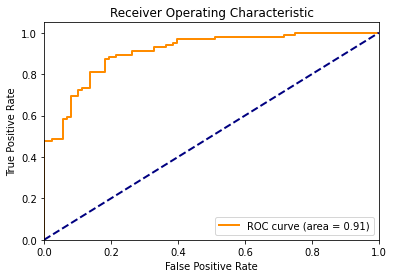

In [25]:
# Calculate the probabilities of the classes
y_prob = rf_random.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('../../data/roc_curve_drought_downsampled.pdf')
plt.show()

In [11]:
# Generate the confusion matrix
#cm = confusion_matrix(y_test, y_pred)

# Define a custom function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title = 'Confusion matrix'
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized ' + title
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
#plot_confusion_matrix(cm, classes=[0, 1])
#plt.savefig('../../data/confusion_matrix_drought_downsampled.pdf')
#plt.show()

#### Repeat random forest with neither downsampling nor upsampling (unbalanced data)

In [15]:
# Separate features (gene expression values) and target (class labels)
## where X = gene expression values and y = class labels
X = labeled.drop("Label",axis=1)
y = labeled["Label"]

In [16]:
# Split the data into training (75%) and testing (25%) sets
# note for future reference: this should be done as early in the process as possible and definitely before any imputation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [17]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across n different combinations, and use all available cores
## where n = number of combinations my computer can handle
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_search_grid, n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
110 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/base.py", line 581, in _validate_params
    validate_parameter_constraints(
  File 

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['sqrt', 'log2',
                                                         'none'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [18]:
# Make predictions on the testing set
y_pred = rf_random.predict(X_test)

In [19]:
# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8785425101214575
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.78      0.84        97
           1       0.87      0.94      0.90       150

    accuracy                           0.88       247
   macro avg       0.88      0.86      0.87       247
weighted avg       0.88      0.88      0.88       247



In [20]:
# find false negative samples
cm = confusion_matrix(y_test, y_pred)
false_negatives = []

for i in range(len(y_test)):
    if y_test.iloc[i] == 1 and y_pred[i] == 0:
        false_negatives.append((X_test.iloc[i], y_test.index[i]))

false_negatives_df = pd.DataFrame([item[0] for item in false_negatives], index=[item[1] for item in false_negatives])
false_negatives_df

,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,Zm00001eb000140,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
SRR11933431,4.056876,1.249386,0.236815,3.601810,2.210226,2.827100,0.000000,3.388387,0.284333,0.251698,...,0.000000,0.000000,0.0,0.00000,0.000000,4.285988,0.0,0.000000,0.0,2.259182
SRR11932997,4.286612,1.325644,0.000000,4.252328,1.241229,4.197022,0.352081,0.000000,0.939185,0.304471,...,0.161725,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
SRR11933391,2.979026,2.058789,0.000000,2.040011,1.977276,0.674075,0.000000,0.000000,0.348251,0.000000,...,0.243039,0.055415,0.0,0.07901,4.537828,0.937702,0.0,0.256119,0.0,1.001413
Oh7BD1D,0.934129,0.971545,0.000000,0.000000,0.000000,0.912784,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
SRR11933154,3.940066,0.573130,0.000000,4.430430,1.758674,3.633742,0.000000,0.000000,1.376002,0.378468,...,0.290882,0.025098,0.0,0.00000,0.000000,0.679096,0.0,0.000000,0.0,0.701097
SRR11932897,4.143946,1.989581,0.530682,4.282688,1.806507,4.359642,0.587102,0.000000,0.000000,1.278714,...,0.324095,0.096976,0.0,0.00000,0.000000,1.518163,0.0,0.000000,0.0,1.782377
SRR11933093,3.681838,1.389175,0.000000,4.087795,3.302334,4.189109,0.561249,3.926742,0.530385,0.460405,...,0.312886,0.000000,0.0,0.00000,0.771087,0.383634,0.0,0.251517,0.0,0.553237
SRR11932853,3.177177,1.262665,1.304464,3.398019,1.794941,2.000963,0.275815,0.000000,1.673221,0.696419,...,0.241036,0.136602,0.0,0.00000,0.272690,0.000000,0.0,0.130056,0.0,0.779499
Tx303D1D,2.054698,0.205120,0.000000,0.000000,0.000000,1.440391,0.000000,0.000000,0.546330,0.000000,...,0.000000,0.000000,0.0,0.00000,0.991855,0.000000,0.0,0.000000,0.0,0.000000


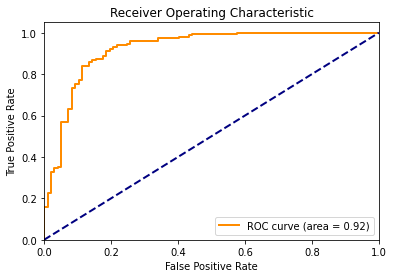

In [21]:
# Calculate the probabilities of the classes
y_prob = rf_random.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('../../data/roc_curve_drought_unbalanced.pdf')
plt.show()

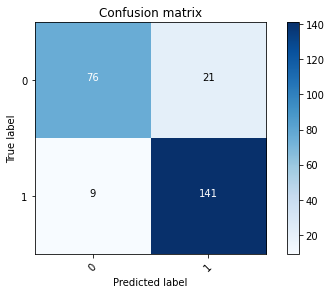

In [22]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# make sure to run the cell above to define the confusion matrix plotting function
# Plot the confusion matrix
plot_confusion_matrix(cm, classes=[0, 1])
plt.savefig('../../data/confusion_matrix_drought_unbalanced.pdf')
plt.show()

#### Random forest with upsampling of minority class (control)

In [12]:
# try upsampling using SMOTE - Serena says this is the default for the Shiu lab these days
# Separate features (gene expression values) and target (class labels)
## where X = gene expression values and y = class labels
X = labeled.drop("Label",axis=1)
y = labeled["Label"]

In [13]:
# Split the data into training (75%) and testing (25%) sets
# note for future reference: this should be done as early in the process as possible and definitely before any imputation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [14]:
# upsample the minority class with SMOTE
# fit the SMOTE
sm = SMOTE(random_state=42)

In [15]:
# do the upsampling
X_res, y_res = sm.fit_resample(X_train,y_train)

In [16]:
# check that the upsampling worked
list(y_res).count(1) == list(y_res).count(0)

True

In [17]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across n different combinations, and use all available cores
## where n = number of combinations my computer can handle
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_search_grid, n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
110 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
47 fits failed with the following error:
Traceback (most recent call last):
  File "/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/base.py", line 581, in _validate_params
    validate_parameter_constraints(
  File 

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['sqrt', 'log2',
                                                         'none'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [18]:
# Make predictions on the testing set
y_pred = rf_random.predict(X_test)

In [19]:
# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8785425101214575
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.78      0.84        97
           1       0.87      0.94      0.90       150

    accuracy                           0.88       247
   macro avg       0.88      0.86      0.87       247
weighted avg       0.88      0.88      0.88       247



In [20]:
# find false negative samples
cm = confusion_matrix(y_test, y_pred)
false_negatives = []

for i in range(len(y_test)):
    if y_test.iloc[i] == 1 and y_pred[i] == 0:
        false_negatives.append((X_test.iloc[i], y_test.index[i]))

false_negatives_df = pd.DataFrame([item[0] for item in false_negatives], index=[item[1] for item in false_negatives])
false_negatives_df

,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,Zm00001eb000140,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
SRR11933431,4.056876,1.249386,0.236815,3.601810,2.210226,2.827100,0.000000,3.388387,0.284333,0.251698,...,0.000000,0.000000,0.0,0.00000,0.000000,4.285988,0.0,0.000000,0.0,2.259182
SRR11932997,4.286612,1.325644,0.000000,4.252328,1.241229,4.197022,0.352081,0.000000,0.939185,0.304471,...,0.161725,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
SRR11933391,2.979026,2.058789,0.000000,2.040011,1.977276,0.674075,0.000000,0.000000,0.348251,0.000000,...,0.243039,0.055415,0.0,0.07901,4.537828,0.937702,0.0,0.256119,0.0,1.001413
Oh7BD1D,0.934129,0.971545,0.000000,0.000000,0.000000,0.912784,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
SRR11933154,3.940066,0.573130,0.000000,4.430430,1.758674,3.633742,0.000000,0.000000,1.376002,0.378468,...,0.290882,0.025098,0.0,0.00000,0.000000,0.679096,0.0,0.000000,0.0,0.701097
SRR11932897,4.143946,1.989581,0.530682,4.282688,1.806507,4.359642,0.587102,0.000000,0.000000,1.278714,...,0.324095,0.096976,0.0,0.00000,0.000000,1.518163,0.0,0.000000,0.0,1.782377
SRR11933093,3.681838,1.389175,0.000000,4.087795,3.302334,4.189109,0.561249,3.926742,0.530385,0.460405,...,0.312886,0.000000,0.0,0.00000,0.771087,0.383634,0.0,0.251517,0.0,0.553237
SRR11932853,3.177177,1.262665,1.304464,3.398019,1.794941,2.000963,0.275815,0.000000,1.673221,0.696419,...,0.241036,0.136602,0.0,0.00000,0.272690,0.000000,0.0,0.130056,0.0,0.779499
Tx303D1D,2.054698,0.205120,0.000000,0.000000,0.000000,1.440391,0.000000,0.000000,0.546330,0.000000,...,0.000000,0.000000,0.0,0.00000,0.991855,0.000000,0.0,0.000000,0.0,0.000000


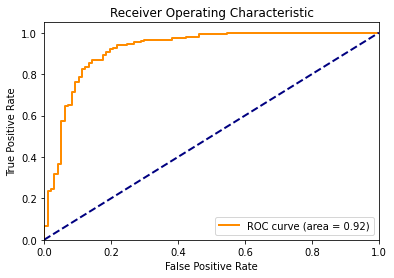

In [21]:
# Calculate the probabilities of the classes
y_prob = rf_random.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('../../data/roc_curve_drought_upsampled.pdf')
plt.show()

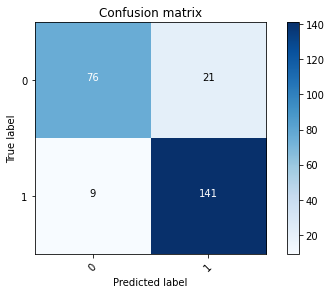

In [22]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# make sure to run the cell above to define the confusion matrix plotting function
# Plot the confusion matrix
plot_confusion_matrix(cm, classes=[0, 1])
plt.savefig('../../data/confusion_matrix_drought_upsampled.pdf')
plt.show()

In [28]:
features = list(X.columns)

In [29]:
feature_importances = rf_random.best_estimator_.feature_importances_

In [30]:
std = np.std([tree.feature_importances_ for tree in rf_random.best_estimator_.estimators_], axis=0)

In [31]:
forest_importances = pd.Series(feature_importances, index=features)

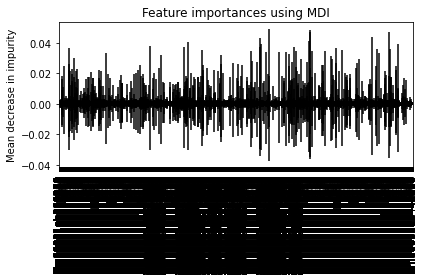

In [33]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()